# Importing the necessary Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
path = ('./crime_data_2.csv')

In [3]:
crimes= pd.read_csv(path)

In [4]:
pd.set_option('display.max_columns',30)
crimes.head(3)

,Unnamed: 0,datetime,address,IL_crime_code,crime_type,crime_description,location_description,arrests,domestic_violence,pbeats,pdistricts,wards,community_areas,FBI_code,year,latitude,longitude,census_tracts,month,day,hour,minute,weekofday,community_area_name,pdistricts_name,district,crime_classification,season,parts_of_day
0,0,2019-04-19 23:48:00,024xx w van buren st,051A,assault,aggravated: handgun,street,False,False,146.0,11,23.0,29,04A,2019.0,41.876072,-87.687615,756.0,4,19,23,48,friday,North Lawndale Chicago,Harrison,West Side,violent_offenses,spring,night
1,1,2019-04-19 23:19:00,025xx w washington blvd,0910,motor vehicle theft,automobile,residential driveway,False,False,77.0,12,46.0,29,07,2019.0,41.882972,-87.689778,37.0,4,19,23,19,friday,North Lawndale Chicago,Near West,West Side,theft,spring,night
2,2,2019-04-19 23:15:00,002xx s hoyne ave,2820,general offense,telephone threat,apartment,False,True,139.0,12,46.0,29,08A,2019.0,41.878279,-87.679011,89.0,4,19,23,15,friday,North Lawndale Chicago,Near West,West Side,general_offenses,spring,night


In [5]:
crimes= crimes.drop(['Unnamed: 0'], axis=1)





## 1. Checking for Correlation between the categorical variables:





In [6]:
crimes.select_dtypes(include='object').columns

Index(['datetime', 'address', 'IL_crime_code', 'crime_type',
       'crime_description', 'location_description', 'FBI_code', 'weekofday',
       'community_area_name', 'pdistricts_name', 'district',
       'crime_classification', 'season', 'parts_of_day'],
      dtype='object')

#### Checking for correlations using cramers's V rule

In [8]:
cor_check= crimes.loc[:,['address', 'IL_crime_code', 'crime_type',
                      'crime_description', 'location_description', 'FBI_code', 'weekofday',
                      'community_area_name', 'pdistricts_name', 'district',
                      'crime_classification', 'season', 'parts_of_day']]

In [7]:
check1= crimes.loc[:,['IL_crime_code','crime_description','location_description',
                      'community_area_name','pdistricts_name', 'district','crime_classification',
                      'season','parts_of_day','weekofday']]

In [8]:
check1.head()

,IL_crime_code,crime_description,location_description,community_area_name,pdistricts_name,district,crime_classification,season,parts_of_day,weekofday
0,051A,aggravated: handgun,street,North Lawndale Chicago,Harrison,West Side,violent_offenses,spring,night,friday
1,0910,automobile,residential driveway,North Lawndale Chicago,Near West,West Side,theft,spring,night,friday
2,2820,telephone threat,apartment,North Lawndale Chicago,Near West,West Side,general_offenses,spring,night,friday
3,0810,over $500,hotel,North Lawndale Chicago,Near West,West Side,theft,spring,night,friday
4,1320,to vehicle,street,North Lawndale Chicago,Central,West Side,criminal_damage,spring,night,friday


In [9]:
%%time
# Define function for matrix for Cramer's V test
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def cramers_v_cross(df):
    columns = df.columns
    chi2_vals = dict()
    for col in columns:
        chi2_vals[col] = [cramers_v(df[col], df[column]) for column in df.columns]
    return pd.DataFrame(chi2_vals, index=columns, columns=columns)

cramers = cramers_v_cross(cor_check)

CPU times: user 6min 21s, sys: 3min 26s, total: 9min 48s
Wall time: 12min 3s


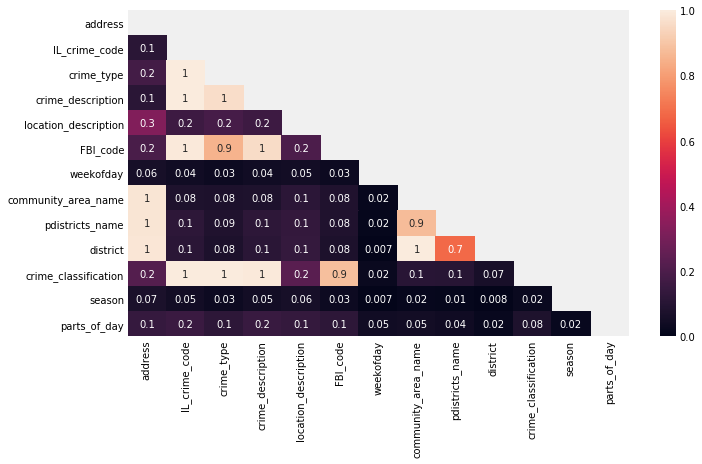

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

mask = np.zeros_like(cramers, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(cramers, mask=mask, annot=True, fmt='.1g', vmin=0, vmax=1)
plt.show()

From above we can see that :

1. **address** is high correlated with **community_area_name**, **district** and, **pdistricts_name**.
2. **IL_crime_code** is high correlated with **crime_classification**,**FBI_code**,**crime_description** and, **crime_type**.
3. **crime_type** is highly correlated with **crime_description**,**crime_classification** and, **FBI_code**.
4. **community_area_name** is highly correlated with **district** and, **pdistricts_name**.
5. **pdistricts_name** is highly correlated with **district**.

 
NOTE: As it can be seen data sufferes from the problem of multicollinearity. So its wise to take one varibale out of these varaibles.

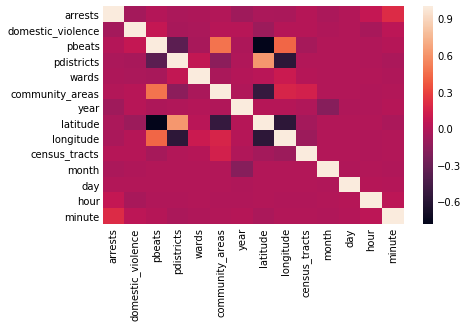

In [11]:
sns.heatmap(crimes.corr())

## 2.  Working with geopandas to check for outliers - if any

In [14]:
import geopandas

In [15]:
#!pip install geopandas

In [16]:
geo_plot = crimes

In [17]:
crimes.head()

,datetime,address,IL_crime_code,crime_type,crime_description,location_description,arrests,domestic_violence,pbeats,pdistricts,wards,community_areas,FBI_code,year,latitude,longitude,census_tracts,month,day,hour,minute,weekofday,community_area_name,pdistricts_name,district,crime_classification,season,parts_of_day
0,2019-04-19 23:48:00,024xx w van buren st,051A,assault,aggravated: handgun,street,False,False,146.0,11,23.0,29,04A,2019.0,41.876072,-87.687615,756.0,4,19,23,48,friday,North Lawndale Chicago,Harrison,West Side,violent_offenses,spring,night
1,2019-04-19 23:19:00,025xx w washington blvd,0910,motor vehicle theft,automobile,residential driveway,False,False,77.0,12,46.0,29,07,2019.0,41.882972,-87.689778,37.0,4,19,23,19,friday,North Lawndale Chicago,Near West,West Side,theft,spring,night
2,2019-04-19 23:15:00,002xx s hoyne ave,2820,general offense,telephone threat,apartment,False,True,139.0,12,46.0,29,08A,2019.0,41.878279,-87.679011,89.0,4,19,23,15,friday,North Lawndale Chicago,Near West,West Side,general_offenses,spring,night
3,2019-04-19 23:00:00,0000x s halsted st,0810,theft,over $500,hotel,False,False,95.0,12,46.0,29,06,2019.0,41.881299,-87.647345,786.0,4,19,23,0,friday,North Lawndale Chicago,Near West,West Side,theft,spring,night
4,2019-04-19 22:40:00,005xx w 14th pl,1320,criminal damage,to vehicle,street,False,False,147.0,1,48.0,29,14,2019.0,41.862452,-87.640013,97.0,4,19,22,40,friday,North Lawndale Chicago,Central,West Side,criminal_damage,spring,night


In [18]:
geo_plot.columns

Index(['datetime', 'address', 'IL_crime_code', 'crime_type',
       'crime_description', 'location_description', 'arrests',
       'domestic_violence', 'pbeats', 'pdistricts', 'wards', 'community_areas',
       'FBI_code', 'year', 'latitude', 'longitude', 'census_tracts', 'month',
       'day', 'hour', 'minute', 'weekofday', 'community_area_name',
       'pdistricts_name', 'district', 'crime_classification', 'season',
       'parts_of_day'],
      dtype='object')

In [20]:
gdf= geopandas.GeoDataFrame(geo_plot,geometry= geopandas.points_from_xy(geo_plot.latitude,geo_plot.longitude))

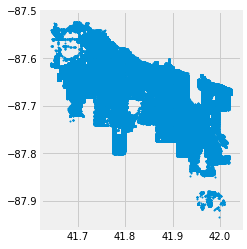

In [22]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

# We restrict to Chicago.
ax = world[world.continent == 'iilinois'].plot(color='white', edgecolor='black')

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, marker='o', markersize=2)

plt.show()

#### Checking for outliers if any

Chicago latitute is from 41.79 to 41.89

In [23]:
print(geo_plot.loc[(geo_plot.latitude < 41.79 ) & (geo_plot.latitude > 41.89 )].count()[0])

0


## 3. Looking at past three years crime

In [16]:
year=['2017','2018','2019']

In [18]:
crimes1=crimes[crimes.year.isin(year)]

In [19]:
crimes1.crime_classification.value_counts()


theft                       243065
violent_offenses            152488
criminal_damage              77030
general_offenses             38292
drug_offenses                28093
iillegal_weapon_offenses     11825
public_indecency              7263
sexual_offenses               7226
child_abuse                   4863
homicide                      1319
kidnapping                     424
Name: crime_classification, dtype: int64

In [20]:
category=['violent_offenses','drug_offenses','iillegal_weapon_offenses','sexual_offenses']

In [21]:
crimes1=crimes1[crimes.crime_classification.isin(category)]

In [22]:
crimes1.crime_classification.value_counts()

violent_offenses            152488
drug_offenses                28093
iillegal_weapon_offenses     11825
sexual_offenses               7226
Name: crime_classification, dtype: int64

In [23]:
crimes2= crimes1.loc[:,['location_description','season','parts_of_day','weekofday','community_area_name','crime_classification']]

In [25]:
crimes2.drop_duplicates(subset=['location_description','season','parts_of_day','weekofday','community_area_name','crime_classification'],inplace=True)

In [99]:
crimes2.to_csv('crime_data_model_ready.csv')